In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import torch
import torchaudio
from tqdm import tqdm
import librosa

from IPython.display import Audio

tqdm.pandas()

# ## huggingface packages
# from datasets import Dataset, ClassLabel
# import evaluate

In [2]:
mps_device = torch.device("mps")

In [3]:
cv_train_tab = pd.read_csv('./cv-archive/cv-valid-train.csv')
cv_test_tab = pd.read_csv('./cv-archive/cv-valid-test.csv')

print(cv_train_tab.shape)
print(cv_test_tab.shape)

cv_train_tab = cv_train_tab.dropna(subset=['accent'])
cv_test_tab = cv_test_tab.dropna(subset=['accent'])

print(cv_train_tab.shape)
print(cv_test_tab.shape)

cv_train_tab.head()

(195776, 8)
(3995, 8)
(64711, 8)
(1338, 8)


,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


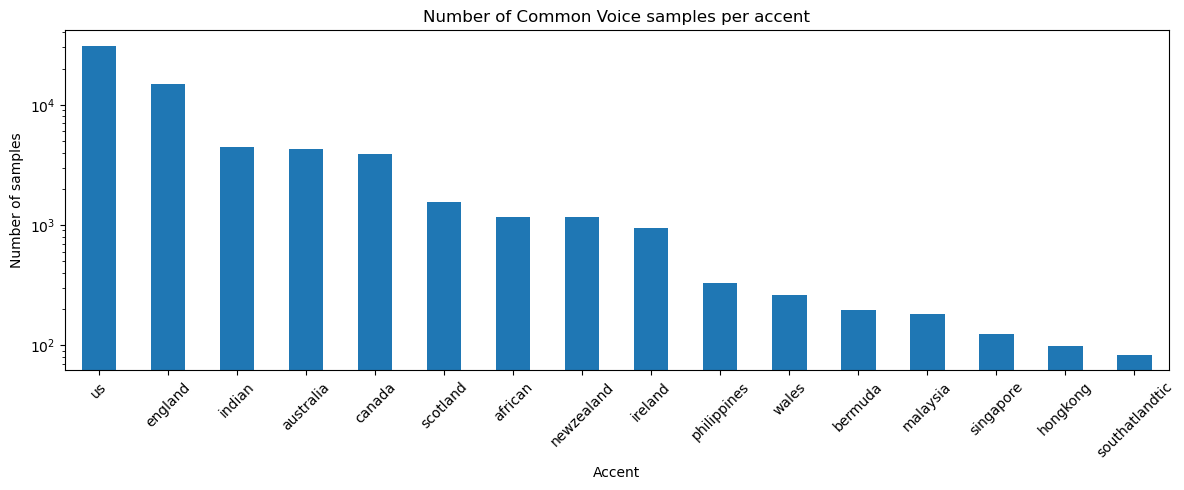

In [4]:
plt.figure(figsize=(12,5))

cv_train_tab['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.savefig('./pictures/cv_accents_bar.png',format='png')
plt.show()

In [5]:
cv_test_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
5,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN
8,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN
9,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN
14,cv-valid-test/sample-000014.mp3,follow the instructions here,1,0,twenties,male,scotland,NaN


In [6]:
CORES = multiprocessing.cpu_count() # Count the number of cores in a computer
print(CORES)

12


In [7]:
multiprocessing.set_start_method('fork')

def f(x): 
    return x + 1 

with multiprocessing.Pool() as pool: 
    print(pool.map(f, range(10))) 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [8]:
def add_path_train(filename):
    path_to_train = './cv-archive/cv-valid-train/'
    if path_to_train not in filename:
        filename = path_to_train+filename
    return(filename)

cv_train_tab['filename'] = cv_train_tab.filename.apply(add_path_train) 
cv_train_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,./cv-archive/cv-valid-train/cv-valid-train/sam...,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,./cv-archive/cv-valid-train/cv-valid-train/sam...,put jackie right on the staff,3,0,seventies,male,us,NaN
13,./cv-archive/cv-valid-train/cv-valid-train/sam...,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,./cv-archive/cv-valid-train/cv-valid-train/sam...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,./cv-archive/cv-valid-train/cv-valid-train/sam...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


In [9]:
def add_path_test(filename):
    path_to_test = './cv-archive/cv-valid-test/'
    if path_to_test not in filename:
        filename = path_to_test+filename
    return(filename)

cv_test_tab['filename'] = cv_test_tab.filename.apply(add_path_test) 
cv_test_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
3,./cv-archive/cv-valid-test/cv-valid-test/sampl...,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
5,./cv-archive/cv-valid-test/cv-valid-test/sampl...,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN
8,./cv-archive/cv-valid-test/cv-valid-test/sampl...,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN
9,./cv-archive/cv-valid-test/cv-valid-test/sampl...,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN
14,./cv-archive/cv-valid-test/cv-valid-test/sampl...,follow the instructions here,1,0,twenties,male,scotland,NaN


## length check

In [10]:
def pull_metadata(filename):
  try:
    metadata = torchaudio.info(filename)
    length = metadata.num_frames / metadata.sample_rate
    return(length)
  except:
    return(float('NaN'))

print(cv_test_tab.iloc[0].filename)

metadata = pull_metadata(cv_train_tab.iloc[0].filename)
print(metadata)

./cv-archive/cv-valid-test/cv-valid-test/sample-000003.mp3
5.836125


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(


In [11]:
pool = multiprocessing.Pool(CORES)
train_lengths = pool.map(pull_metadata, cv_train_tab.filename)
test_lengths = pool.map(pull_metadata, cv_test_tab.filename)
pool.close()

In [12]:
index_meta, = np.where(~np.isnan(train_lengths))
index_nometa,= np.where(np.isnan(train_lengths))

print(len(index_meta),len(index_nometa))

train_lengths = np.array(train_lengths)
test_lengths = np.array(test_lengths)

64711 0


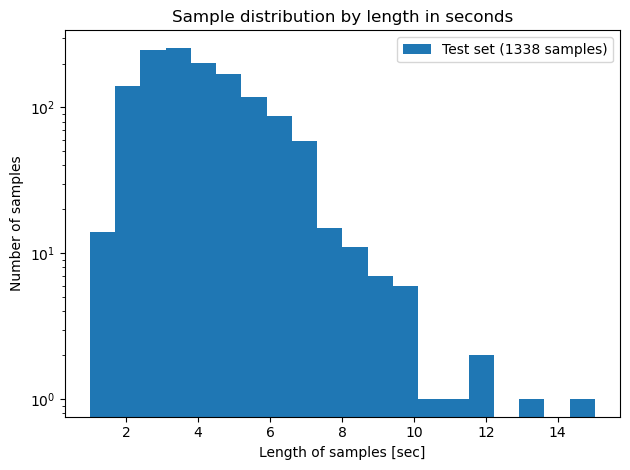

15.028125


In [13]:
plt.hist(test_lengths,bins=20,
         label='Test set ('+str(len(test_lengths))+' samples)')
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Length of samples [sec]')
plt.title('Sample distribution by length in seconds')
plt.legend()
plt.tight_layout()
plt.savefig('./pictures/cv_test_length_hist.png',format='png')
plt.show()

print(np.max(test_lengths))

64711 64699


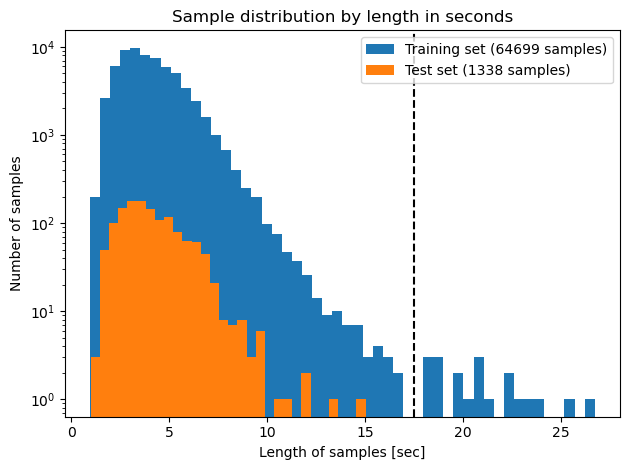

In [14]:
index_long, = np.where(train_lengths < 30)

print(len(index_meta),len(index_long))

plt.hist(train_lengths[index_long],bins=50,
         label='Training set ('+str(len(train_lengths[index_long]))+\
         ' samples)')
plt.hist(test_lengths,bins=30,
         label='Test set ('+str(len(test_lengths))+' samples)')

CUTOFF = 17.5

plt.axvline(CUTOFF,ls='--',color='k')

plt.yscale('log')

plt.ylabel('Number of samples')
plt.xlabel('Length of samples [sec]')
plt.title('Sample distribution by length in seconds')
plt.legend()
plt.tight_layout()
plt.savefig('./pictures/cv_train_length_hist.png',format='png')
plt.show()

In [15]:
if 'length' not in cv_train_tab:
    cv_train_tab['length'] = train_lengths

cv_test_tab['length'] = test_lengths

print(cv_train_tab.shape)
print(cv_train_tab[cv_train_tab.length<CUTOFF].shape)

cv_train_tab = cv_train_tab[cv_train_tab.length<CUTOFF]

cv_train_tab.head()

(64711, 9)
(64679, 9)


,filename,text,up_votes,down_votes,age,gender,accent,duration,length
5,./cv-archive/cv-valid-train/cv-valid-train/sam...,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,5.836125
8,./cv-archive/cv-valid-train/cv-valid-train/sam...,put jackie right on the staff,3,0,seventies,male,us,NaN,1.732125
13,./cv-archive/cv-valid-train/cv-valid-train/sam...,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,4.228125
14,./cv-archive/cv-valid-train/cv-valid-train/sam...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,5.380125
19,./cv-archive/cv-valid-train/cv-valid-train/sam...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,3.740125


## quality control

In [16]:
print(cv_train_tab[cv_train_tab.down_votes>0].shape)
print(cv_train_tab[cv_train_tab.down_votes==0].shape)
print(cv_train_tab[cv_train_tab.up_votes>cv_train_tab.down_votes].shape)

print(cv_test_tab[cv_test_tab.down_votes==0].shape)

(5419, 9)
(59260, 9)
(64669, 9)
(1217, 9)


In [17]:
cv_train_tab = cv_train_tab[cv_train_tab.down_votes==0]
cv_test_tab = cv_test_tab[cv_test_tab.down_votes==0]

print(cv_train_tab.shape,cv_test_tab.shape)

(59260, 9) (1217, 9)


In [18]:
ACCENTS = ['us','england','scotland','australia','ireland','canada']#,'wales',]
ACCENTS = ['us','england','scotland','australia','ireland','canada']
# ACCENTS = ['england','australia']

print(cv_train_tab[cv_train_tab.accent.isin(ACCENTS)].shape)
print(cv_train_tab.shape)

print(cv_test_tab[cv_test_tab.accent.isin(ACCENTS)].shape)
print(cv_test_tab.shape)

(52094, 9)
(59260, 9)
(1077, 9)
(1217, 9)


In [19]:
cv_train_tab = cv_train_tab[cv_train_tab.accent.isin(ACCENTS)]
cv_test_tab = cv_test_tab[cv_test_tab.accent.isin(ACCENTS)]

In [20]:
label2id, id2label = dict(), dict()
for i, label in enumerate(ACCENTS):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

cv_train_tab['label'] = cv_train_tab['accent'].apply(lambda x: label2id[x])
cv_test_tab['label'] = cv_test_tab['accent'].apply(lambda x: label2id[x])

cv_train_tab.head()

{0: 'us', 1: 'england', 2: 'scotland', 3: 'australia', 4: 'ireland', 5: 'canada'} 

 {'us': 0, 'england': 1, 'scotland': 2, 'australia': 3, 'ireland': 4, 'canada': 5}


,filename,text,up_votes,down_votes,age,gender,accent,duration,length,label
5,./cv-archive/cv-valid-train/cv-valid-train/sam...,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,5.836125,0
8,./cv-archive/cv-valid-train/cv-valid-train/sam...,put jackie right on the staff,3,0,seventies,male,us,NaN,1.732125,0
13,./cv-archive/cv-valid-train/cv-valid-train/sam...,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,4.228125,0
14,./cv-archive/cv-valid-train/cv-valid-train/sam...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,5.380125,1
19,./cv-archive/cv-valid-train/cv-valid-train/sam...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,3.740125,3


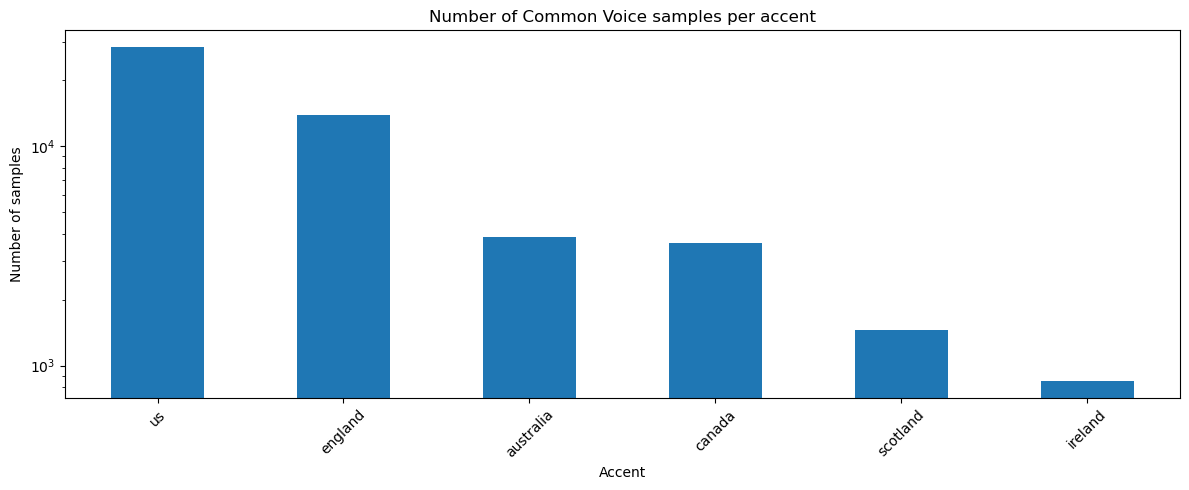

In [21]:
plt.figure(figsize=(12,5))

cv_train_tab['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.show()

In [22]:
import sklearn
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=np.array(ACCENTS), y=cv_train_tab['accent'])
class_weights = dict(zip(ACCENTS, weights))
print(class_weights)

{'us': 0.30611477394257774, 'england': 0.6235516613999809, 'scotland': 5.946803652968036, 'australia': 2.2423381542699725, 'ireland': 10.22654102866117, 'canada': 2.3944658944658945}


In [23]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=83, sampling_strategy='auto')
# ros = RandomOverSampler(random_state=83, sampling_strategy='all')
y = cv_train_tab['label']
cv_train_tab_rus = cv_train_tab.drop(['label'], axis=1)
cv_train_tab_rus, y_resampled = rus.fit_resample(cv_train_tab, y)
del y
cv_train_tab_rus['label'] = y_resampled
del y_resampled

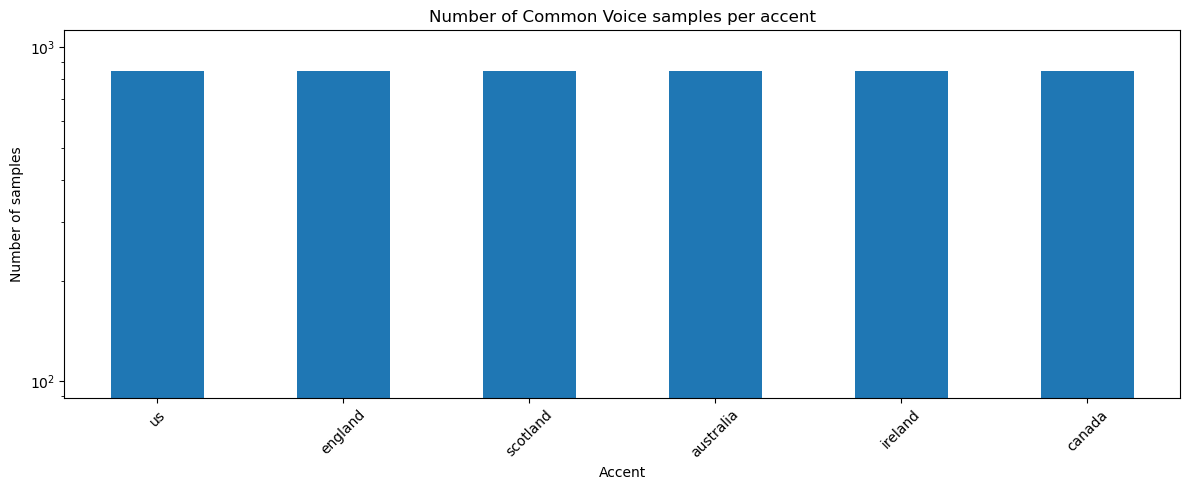

In [24]:
plt.figure(figsize=(12,5))

cv_train_tab_rus['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.show()

In [25]:
weights = compute_class_weight(class_weight='balanced', classes=np.array(ACCENTS), y=cv_train_tab['accent'])
class_weights = dict(zip(ACCENTS, weights))
print(class_weights)

{'us': 0.30611477394257774, 'england': 0.6235516613999809, 'scotland': 5.946803652968036, 'australia': 2.2423381542699725, 'ireland': 10.22654102866117, 'canada': 2.3944658944658945}


In [26]:
cv_train_tab = cv_train_tab_rus

# looking at the data

In [27]:
lookat_file = cv_test_tab.iloc[3]
lookat_file

filename      ./cv-archive/cv-valid-test/cv-valid-test/sampl...
text                               follow the instructions here
up_votes                                                      1
down_votes                                                    0
age                                                    twenties
gender                                                     male
accent                                                 scotland
duration                                                    NaN
length                                                 2.324125
label                                                         2
Name: 14, dtype: object

torch.Size([1, 257, 145])


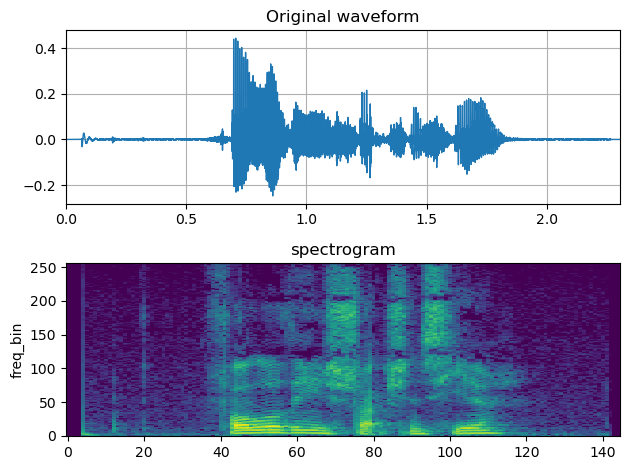

In [28]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
waveform, sample_rate = torchaudio.load(lookat_file.filename)

NFFT = 512
RESAMPLE_RATE=16000
spectrogram = torchaudio.transforms.Spectrogram(n_fft=NFFT)

# Perform transform
transform = torchaudio.transforms.Resample(sample_rate, RESAMPLE_RATE)
audio_prime = transform(waveform)

spec = spectrogram(audio_prime)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

print(spec.shape)

from IPython.display import Audio 
Audio(audio_prime.numpy()[0], rate=RESAMPLE_RATE)


In [29]:
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=NFFT,power=2)
recon_waveform = griffin_lim(spec)

from IPython.display import Audio 
Audio(recon_waveform.numpy()[0], rate=RESAMPLE_RATE)

In [30]:
RESAMPLE_RATE=16000
transform = torchaudio.transforms.Resample(sample_rate, RESAMPLE_RATE)
audio_prime = transform(waveform).squeeze(0).numpy().reshape(-1)

from IPython.display import Audio 
Audio(audio_prime, rate=RESAMPLE_RATE)

# running the pretrained model

In [31]:
from speechbrain.inference import EncoderClassifier

# Load the ECAPA-TDNN based accent classifier
classifier = EncoderClassifier.from_hparams(
    source="Jzuluaga/accent-id-commonaccent_ecapa",
    savedir="pretrained_models/accent-id-ecapa"
)
# Classify the audio
out_prob, score, index, text_lab = classifier.classify_file(lookat_file.filename)

# Print results
print(f"Predicted Accent: {text_lab[0]}")

/opt/anaconda3/lib/python3.12/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
CategoricalEncoder.expect_len was never called: assuming category count of 16 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.


Predicted Accent: scotland


In [32]:
def classify_pretrained(file):
    out_prob, score, index, text_lab = classifier.classify_file(file)
    return(text_lab[0])

pool = multiprocessing.Pool(CORES)
predict_accent = []
for result in tqdm(pool.imap_unordered(classify_pretrained, cv_test_tab.filename), total=len(cv_test_tab.filename)):
    predict_accent.append(result)
pool.close()

100%|███████████████████████████████████████| 1077/1077 [00:20<00:00, 51.98it/s]


['african' 'australia' 'canada' 'england' 'indian' 'ireland' 'newzealand'
 'scotland' 'us']
accuracy: 0.42618384401114207


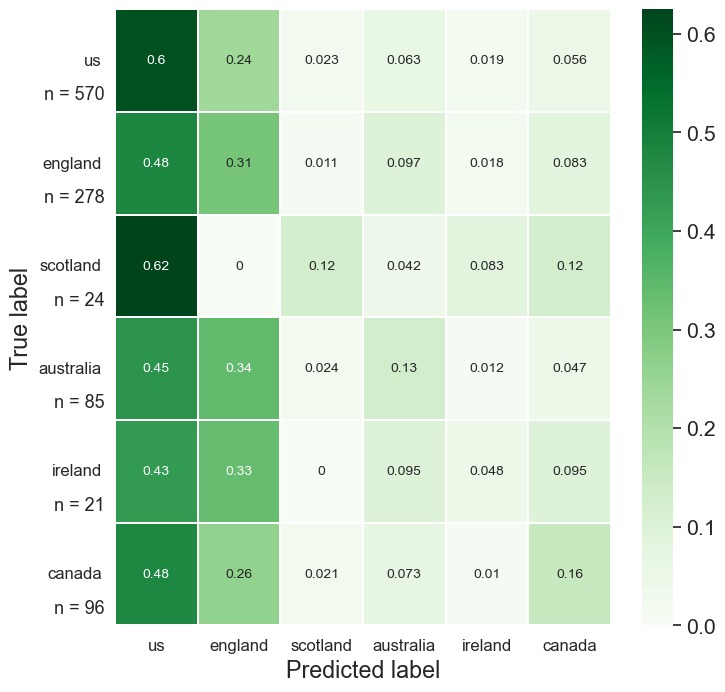

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

print(np.unique(predict_accent))

print(f"accuracy: {np.sum(predict_accent == cv_test_tab.accent)/len(cv_test_tab.filename)}")

class_names = ACCENTS
matrix = confusion_matrix(cv_test_tab['accent'],predict_accent,labels=class_names)
num_true = matrix.sum(axis=1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names,fontsize=12)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=12)
for i in range(len(num_true)):
    plt.text(-0.12,tick_marks2[i]+0.38,'n = '+ str(num_true[i]),ha='right',fontsize=13)
plt.xlabel('Predicted label')
plt.ylabel('True label')
# plt.title('Confusion Matrix for Random Forest Model Validation Set')
plt.show()

In [34]:
# making a convolutional nn based thing for spectrograms

# spectral datasets

In [35]:
class SpectralDataset:
    def __init__(self, df, sample_rate=RESAMPLE_RATE, max_duration=CUTOFF,nfft=NFFT):
        self.df = df.copy(deep=True)
        self.sample_rate = sample_rate
        self.max_length = int(sample_rate * max_duration)  # e.g., 5 seconds
        self.label_encoder = LabelEncoder()
        self.nfft = nfft
        self.spectrogram = torchaudio.transforms.Spectrogram(n_fft=self.nfft)
        self.df['accent'] = self.label_encoder.fit_transform(df['accent'])
        self.accent_id = dict(enumerate(self.label_encoder.classes_))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filename']
        label = row['accent']

        # Load audio
        wav, sr = torchaudio.load(path)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            wav = resampler(wav)

        # Remove channel dimension
        wav = wav.squeeze(0)

        # Truncate or pad as needed
        num_samples = self.max_length
        if wav.shape[0] > num_samples:
            wav = wav[:num_samples]
        elif wav.shape[0] < num_samples:
            pad_len = num_samples - wav.shape[0]
            wav = torch.nn.functional.pad(wav, (0, pad_len))

        wav = wav.unsqueeze(0)
        
        wav += -1*torch.median(wav)
        wav *= 1/torch.max(wav)
        
        spec = self.spectrogram(wav)
        
        return spec, torch.tensor(label, dtype=torch.long)

In [36]:
# wav, sr = torchaudio.load(lookat_file.filename)

# # Resample if needed
# if sr != RESAMPLE_RATE:
#     resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=RESAMPLE_RATE)
#     wav = resampler(wav)

# # Remove channel dimension
# wav = wav.squeeze(0)
# print(wav.shape)

# # Truncate or pad as needed
# num_samples = int(RESAMPLE_RATE*CUTOFF)
# if wav.shape[0] > num_samples:
#     wav = wav[:num_samples]
# elif wav.shape[0] < num_samples:
#     pad_len = num_samples - wav.shape[0]
#     wav = torch.nn.functional.pad(wav, (0, pad_len))

# print(wav.shape)
# spec = spectrogram(wav)
# print(spec.shape)
# print(num_samples/256)

In [37]:
import torch.nn as nn
from torch.utils.data import random_split
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

# running on speech accent archive

In [38]:
df = pd.read_csv('SpeechAccentArchive/audio_metadata.csv')
countries = np.array(df['country'])
scripts = np.array(df['transcript'])
audio_paths = np.array(df['path'])

mask = np.array([len(countries[ind].split(',')) == 1 for ind in range(len(countries))], dtype=bool) # remove samples from multiple countries
countries, scripts, audio_paths = countries[mask], scripts[mask], audio_paths[mask]
countries = countries.astype(object)
countries[countries == 'ausstralia'] = 'australia'
countries[countries == 'USA'] = 'usa'
counts = df['country'].value_counts()

df_data = pd.DataFrame({'filename': audio_paths, 'accent': countries})
df_data['accent'] = df_data['accent'].apply(lambda x: x if counts[x] >= 2 else 'Other') # classifies accents with <2 samples as "Other"
counts = df_data['accent'].value_counts()
print(counts)
ACCENTS_SAA = ['usa','uk','canada','australia']#,'ireland']
df_data = df_data[df_data.accent.isin(ACCENTS_SAA)]
# df_data.head()

accent
usa             435
uk               45
canada           42
australia        37
ireland          12
Other             7
new zealand       6
singapore         5
south africa      4
jamaica           2
Name: count, dtype: int64


torch.Size([1, 257, 1233])


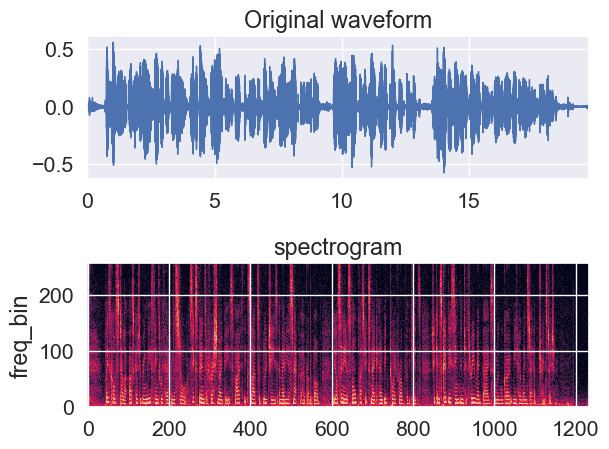

In [39]:
lookat_saa_file = df_data.iloc[2]

waveform, sample_rate = torchaudio.load(lookat_saa_file.filename)

spectrogram = torchaudio.transforms.Spectrogram(n_fft=NFFT)

transform = torchaudio.transforms.Resample(sample_rate, RESAMPLE_RATE)
audio_prime = transform(waveform)

spec = spectrogram(audio_prime)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

print(spec.shape)

In [40]:
from IPython.display import Audio 
Audio(audio_prime, rate=RESAMPLE_RATE)

In [41]:
NFFT = 512
CUTOFF = 30

train_df, val_df = train_test_split(
    df_data,
    test_size=0.2,
    stratify=df_data['accent'],  # ensures all classes are represented
    random_state=42
)

train_ds = SpectralDataset(train_df)
val_ds = SpectralDataset(val_df)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
dls = DataLoaders(train_dl, val_dl)

# Set up model
num_accents = len(ACCENTS)

initial_2d = (int(NFFT/2+1),int(np.ceil(RESAMPLE_RATE*CUTOFF/NFFT*2)))
print(initial_2d)

xb,yb = first(dls.valid)

simple_net = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, padding=3//2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=3, padding=3//2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # nn.Conv2d(8, 16, kernel_size=3, padding=3//2),     
        # nn.MaxPool2d(2),
        # nn.ReLU(),
        Flatten(),
        nn.Linear(139776,400),
        nn.ReLU(),
        nn.Linear(400,num_accents),
        )

simple_net(xb).shape
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
# learn.recorder.train_metrics = True

learn.recorder.valid_metrics = True
learn.summary()

(257, 1875)


Sequential (Input shape: 16 x 1 x 257 x 1094)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 4 x 257 x 1094 
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 4 x 128 x 547  
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 8 x 128 x 547  
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 8 x 64 x 273   
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 1397

In [42]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.266699,1.169269,0.767857,00:13


In [43]:
preds, _ = learn.get_preds(dl=val_dl)
pred_classes = preds.argmax(dim=1)

0.7678571428571429


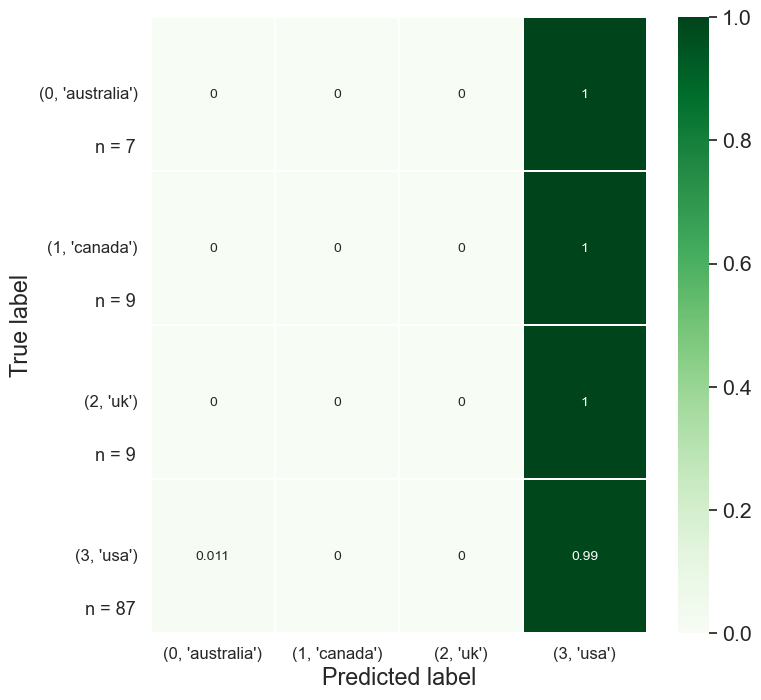

In [44]:
accuracy_val = accuracy_score(val_ds.df['accent'],pred_classes)
print(accuracy_val)

matrix = confusion_matrix(val_ds.df['accent'],pred_classes)
num_true = matrix.sum(axis=1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
class_names = val_ds.accent_id.items()
# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names,fontsize=12)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=12)
for i in range(len(num_true)):
    plt.text(-0.12,tick_marks2[i]+0.38,'n = '+ str(num_true[i]),ha='right',fontsize=13)
plt.xlabel('Predicted label')
plt.ylabel('True label')
# plt.title('Confusion Matrix for Random Forest Model Validation Set')
plt.show()

# running on my data

In [45]:
NFFT = 512
CUTOFF = 7.5
RESAMPLE_RATE = 16000

train_df, val_df = train_test_split(
    cv_train_tab,
    test_size=0.2,
    stratify=cv_train_tab['accent'],  # ensures all classes are represented
    random_state=42
)

train_ds = SpectralDataset(train_df,nfft=NFFT,sample_rate=RESAMPLE_RATE)
val_ds = SpectralDataset(val_df,nfft=NFFT,sample_rate=RESAMPLE_RATE)

print(train_ds.accent_id)
print(val_ds.accent_id)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
dls = DataLoaders(train_dl, val_dl)

# Set up model
num_accents = len(ACCENTS)
features = 32

initial_2d = (int(np.ceil(RESAMPLE_RATE*CUTOFF/NFFT*2)),int(NFFT/2+1),)

sample_input, _ = train_ds[0]
data_dim = np.prod(sample_input.shape)

xb,yb = first(dls.valid)

safe_net = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(1, 4, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(8, 16, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 4, kernel_size=7, padding=7//2),
        nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(1856,16),
        nn.ReLU(),
        nn.Linear(16,16),
        nn.ReLU(),
        nn.Linear(16,num_accents),
        )

simple_net = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=5, padding=3//2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=5, padding=3//2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # nn.Conv2d(8, 16, kernel_size=3, padding=3//2),     
        # nn.MaxPool2d(2),
        # nn.ReLU(),
        Flatten(),
        nn.Linear(57040,2*features),
        nn.ReLU(),
        nn.Linear(2*features, features),
        nn.ReLU(),
        nn.Linear(features,num_accents),
        )

linear_net = nn.Sequential(
        Flatten(),
        nn.BatchNorm1d(data_dim),
        nn.Linear(data_dim, features),
        nn.BatchNorm1d(features),
        nn.ReLU(),
        nn.Linear(features, 2*features),
        nn.BatchNorm1d(2*features),
        nn.ReLU(),
        nn.Linear(2*features, 2*features),
        nn.BatchNorm1d(2*features),
        nn.ReLU(),
        nn.Linear(2*features, 2*features),
        nn.BatchNorm1d(2*features),
        nn.ReLU(),
        nn.Linear(2*features, num_accents),
        )

conv_net = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(1, 2, kernel_size=(1,7), padding=0,stride=(1,4)),
        nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        # nn.MaxPool2d(2),
        nn.Conv2d(2, 4, kernel_size=(1,3), padding=0,stride=(1,3)),
        nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        # nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(16, 2, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(1280,64),
        nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Linear(64,2*num_accents),
        nn.BatchNorm1d(2*num_accents, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Linear(2*num_accents,num_accents),
        )

conv_long_net = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(1, 32, kernel_size=(1,7), padding=0,stride=(1,4)),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        # nn.MaxPool2d(2),
        nn.Conv2d(32, 32, kernel_size=(1,3), padding=0,stride=(1,3)),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        # nn.MaxPool2d(2),
        nn.Conv2d(32, 32, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=(1,3), padding=0,stride=(1,2)),
        nn.BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(1280,64),
        nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Linear(64,2*num_accents),
        nn.BatchNorm1d(2*num_accents, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Linear(2*num_accents,num_accents),
        )

conv_net(xb).shape
learn = Learner(dls, conv_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
learn.recorder.train_metrics = True
learn.recorder.valid_metrics = True
learn.summary()


{0: 'australia', 1: 'canada', 2: 'england', 3: 'ireland', 4: 'scotland', 5: 'us'}
{0: 'australia', 1: 'canada', 2: 'england', 3: 'ireland', 4: 'scotland', 5: 'us'}


Sequential (Input shape: 64 x 1 x 257 x 1094)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 1 x 257 x 1094 
BatchNorm2d                               2          True      
____________________________________________________________________________
                     64 x 2 x 257 x 272  
Conv2d                                    16         True      
BatchNorm2d                               4          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 4 x 257 x 90   
Conv2d                                    28         True      
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 257 x 44   
Conv2d                                    1

In [46]:
# learn.lr_find()

In [47]:
learn.fit(50)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.849114,0.170307,1.838914,0.180569,00:42
1,1.827388,0.177914,1.816863,0.181551,00:40
2,1.811184,0.185521,1.806025,0.190383,00:41
3,1.796114,0.198282,1.799157,0.196271,00:43
4,1.787575,0.207362,1.792135,0.210010,00:42
5,1.775211,0.213742,1.788936,0.212954,00:43
6,1.768739,0.221104,1.780747,0.216879,00:43
7,1.763079,0.229448,1.777462,0.218842,00:43
8,1.754122,0.238528,1.774811,0.231600,00:43
9,1.747924,0.241472,1.774116,0.222767,00:42


In [48]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
        ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

_resnet_stem(3,32,32,64)
# rn = ResNet(dls, [2,2,2,2])

# learn = get_learner(rn)

# learn.summary()

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [49]:
test_ds = SpectralDataset(cv_test_tab)
test_dl = DataLoader(test_ds, batch_size=16)
preds, _ = learn.get_preds(dl=test_dl)
pred_classes = preds.argmax(dim=1)

In [50]:
accuracy_testset = accuracy_score(test_ds.df['accent'],pred_classes)
print(accuracy_testset)

0.233983286908078


{0: 'australia', 1: 'canada', 2: 'england', 3: 'ireland', 4: 'scotland', 5: 'us'}


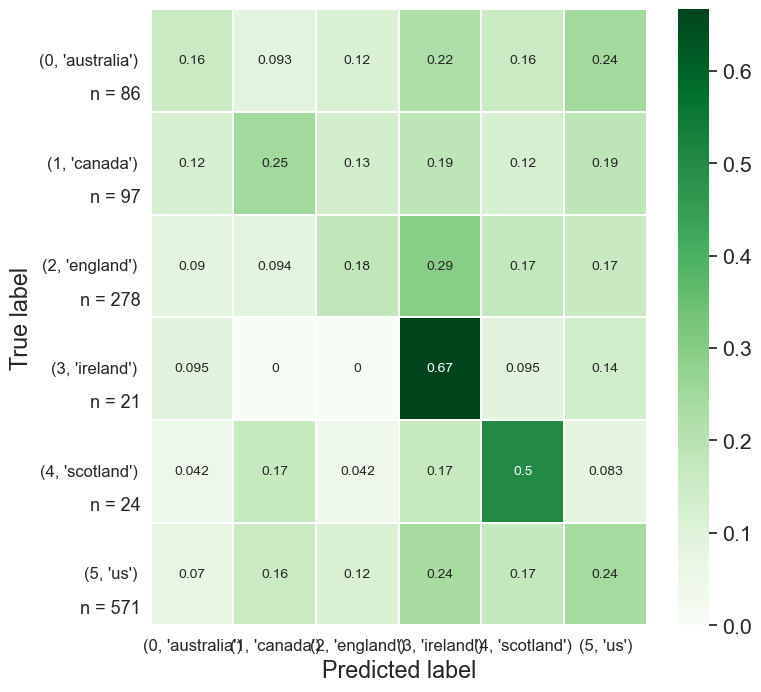

In [51]:
matrix = confusion_matrix(test_ds.df['accent'],pred_classes)
print(test_ds.accent_id)
num_true = matrix.sum(axis=1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
class_names = test_ds.accent_id.items()
# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names,fontsize=12)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=12)
for i in range(len(num_true)):
    plt.text(-0.12,tick_marks2[i]+0.38,'n = '+ str(num_true[i]),ha='right',fontsize=13)
plt.xlabel('Predicted label')
plt.ylabel('True label')
# plt.title('Confusion Matrix for Random Forest Model Validation Set')
plt.show()

In [112]:
# learn.path = './models/'

# learn.save(file='model_save',with_opt=True)

Path('models/model_save.pth')

# using anusha's model

In [ ]:
max_duration = CUTOFF
sample_rate = 16000

class AccentDataset:
    def __init__(self, df, sample_rate=sample_rate, max_duration=max_duration):
        self.df = df.copy(deep=True)
        self.sample_rate = sample_rate
        self.max_length = int(sample_rate * max_duration)  # e.g., 5 seconds
        self.label_encoder = LabelEncoder()
        self.df['accent'] = self.label_encoder.fit_transform(df['accent'])
        self.accent_id = dict(enumerate(self.label_encoder.classes_))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filename']
        label = row['accent']

        # Load audio
        wav, sr = torchaudio.load(path)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            wav = resampler(wav)

        # Remove channel dimension
        wav = wav.squeeze(0)

        # Truncate or pad as needed
        num_samples = self.max_length
        if wav.shape[0] > num_samples:
            wav = wav[:num_samples]
        elif wav.shape[0] < num_samples:
            pad_len = num_samples - wav.shape[0]
            wav = torch.nn.functional.pad(wav, (0, pad_len))

        # return torch.tensor(wav, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        return wav.detach().clone().requires_grad_(True), torch.tensor(label, dtype=torch.long)

In [ ]:
# Split data into training and validation
num_train = int(0.8 * len(cv_train_tab))
num_val = len(cv_train_tab) - num_train

print(num_train,num_val)

In [ ]:
import torch.nn as nn
from torch.utils.data import random_split
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

train_df, val_df = train_test_split(
    cv_train_tab,
    test_size=0.2,
    stratify=cv_train_tab['accent'],  # ensures all classes are represented
    random_state=42
)

train_ds = AccentDataset(train_df)
val_ds = AccentDataset(val_df)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
dls = DataLoaders(train_dl, val_dl)

# Set up model
features = 2**6 # runs out of RAM >2**10
data_dim = int(sample_rate*max_duration)
num_countries = len(set(cv_train_tab['accent']))

simple_net = nn.Sequential(
            nn.Linear(data_dim, features),
            nn.ReLU(),
            nn.Linear(features, num_countries)
        )

playful_net = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(256, num_countries)
        )

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
# learn.recorder.train_metrics = True
learn.recorder.valid_metrics = True
learn.fit(5) # argument in parentheses is number of epoch
    

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(L(learn.recorder.values).itemgot(2))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Final accuracy: {learn.recorder.values[-1][2]}")

In [ ]:
test_ds = AccentDataset(cv_test_tab)
test_dl = DataLoader(test_ds, batch_size=16)
preds, _ = learn.get_preds(dl=test_dl)
pred_classes = preds.argmax(dim=1)

In [ ]:
[print(int(pred_classes[i]), list(test_ds.df['accent'])[i]) for i in range(len(pred_classes))];